In [1]:
# use kernel py3-6
#import goatools
from goatools import obo_parser
import re
import json
import numpy as np
import pandas as pd
from goatools.go_enrichment import GOEnrichmentStudy
import matplotlib.pyplot as plt
import os

ModuleNotFoundError: No module named 'goatools'

In [2]:
def matchgff2(feature, gff_file='/home/t44p/PW_rawdata/Transciptome_GenomeAnnotation/Xele_annotated2_gff_export2.gff', obo_path="/home/t44p/PW_rawdata/go_obo/go.obo", namespace=None, depth_threshold=0, goea=False):
    """
    Searches a GFF (General Feature Format) file for specific features and retrieves associated Gene Ontology (GO) terms,
    with optional filtering by GO term namespace and depth.

    Parameters:
    ----------
    feature : list or iterable
        An iterable of strings representing the features to search for in the GFF file.

    gff_file : str, optional
        The file path to the GFF file. Defaults to a predefined path.

    obo_path : str, optional
        The file path to the Gene Ontology .obo file. Defaults to a predefined path.

    namespace : list of str or None, optional
        List of GO term namespaces to filter term count results. Valid options are 'biological_process', 
        'molecular_function', 'cellular_component', or None. Defaults to None (no filtering).

    depth_threshold : int, optional
        Minimum depth of GO terms to include in the results. Defaults to 0 (no filtering).

    goea : bool, optional
        Whether to perform Gene Ontology Enrichment Analysis. Defaults to False.

    Returns:
    -------
    tuple
        A tuple containing:
        1. A dictionary with features as keys and lists of lines from the GFF file as values.
        2. A dictionary mapping features to their associated GO terms.
        3. A dictionary of GO term counts.
        4. GOEA results (if goea is True), filtered by the specified depth threshold for all namespaces

    Notes:
    -----
    - The function uses regular expressions for precise matching of features.
    - It extracts GO IDs from matched lines and retrieves their corresponding names and namespaces.
    - It is possible for the rawcounts to filter for namespaces 
    - If `goea` is True, the function performs GO Enrichment Analysis and returns the results filtered by the specified depth threshold but not for namespaces. 
    - The Enrichment analysis will be performed across all namespaces, filtering parameter "namespace" will have no effect on the enrichment analysis
    
    """

    valid_namespaces = {'biological_process', 'molecular_function', 'cellular_component', None}
    # Check if namespace is a list containing only valid elements
    if isinstance(namespace, list) and not all(ns in valid_namespaces for ns in namespace):
        raise ValueError("Invalid namespace provided. Valid options are 'biological_process', "
                         "'molecular_function', 'cellular_component', or a list containing any of these. "
                         "You can also use None for no filtering.")

    with open(gff_file, 'r') as file:
        go_ontology = obo_parser.GODag(obo_path)
        
        lines_where_feat_found = {}
        go_ids = {}
        background_genes = []
        go_term_count = {}

         # Find the depth of each GO term
        go_depths = {go_id: go_term.depth for go_id, go_term in go_ontology.items()}

        # construct background genes
        if goea:
            for line in file:
                if not line.lstrip().startswith('#'):
                    background_genes.append(line.split('\t')[0])

        for feat in feature:
            file.seek(0)  # reset file pointer to the beginning for each feature
            lines_where_feat_found[feat] = []
            go_ids[feat] = {}
            pattern = re.compile(re.escape(feat) + r'\t')  # exact match followed by a tab
            for line in file:
                if pattern.search(line):
                    lines_where_feat_found[feat].append(line.strip())  # Store the line (as a string) if feature is found
                    # Extract GO id
                    match = re.search(r"Ontology_id=([GO:\d,]+)", line.strip())
                    if match:
                        ids = match.group(1).split(',')
                        # Map Terms to Ids and Count Occurrences
                        for id in ids:
                            term = go_ontology.get(id)
                            if term is not None:
                                go_ids[feat][id] = {'name': term.name, 'namespace': term.namespace}

                                if namespace is None or term.namespace in namespace and go_ontology[id].depth >= depth_threshold:
                                    # Count Occurrences
                                    if id in go_term_count:
                                        go_term_count[id] = (term.name, go_term_count[id][1] + 1, term.namespace)
                                    else:
                                        go_term_count[id] = (term.name, 1, term.namespace)
                            else:
                                go_ids[feat][id] = {'name': None, 'namespace': None}
                                if id not in go_term_count:
                                    go_term_count[id] = (None, 1)
        if goea:
            print("GO Enrichment Analysis >>")
            goea_obj = GOEnrichmentStudy(
                background_genes,
                go_ids,  # This needs to be a dict mapping gene IDs to a set of GO IDs
                go_ontology,
                propagate_counts=False,
                alpha=0.05,  # significance level for the statistical test
                methods=['fdr_bh']  # correction method for multiple testing
            )
            goea_result = goea_obj.run_study(go_ids.keys())

            # filter based on depth
            filtered_goea_results = [res for res in goea_result if res.goterm.depth >= depth_threshold]
            return lines_where_feat_found, go_ids, go_term_count, filtered_goea_results


        return lines_where_feat_found, go_ids, go_term_count
    

def tabulate(term_count_dict, sort=True):
    """
    Prints a tabulated view of the term counts from a dictionary, such as the one returned by matchgff2.

    Parameters:
    ----------
    term_count_dict : dict
        A dictionary where keys are Gene Ontology (GO) IDs, and values are tuples containing the GO term name, 
        the count of occurrences, and optionally the namespace. 
        The structure is typically: {GO_ID: (GO_Term, Count, Namespace)}.

    sort : bool, optional
        Whether to sort the output based on the count of occurrences of each GO term. Defaults to True.

    Description:
    ------------
    This function iterates through the term_count_dict and prints each GO term's count, ID, name, and namespace 
    in a tabular format. It can optionally sort these terms based on their count in descending order.

    Note:
    -----
    The function is primarily a utility for visualizing the output of the matchgff2 function. It does not return any value 
    but prints the information directly to the console.

    Example Usage:
    --------------
    go_term_count = {'GO:0000001': ('term1', 5, 'biological_process'), 'GO:0000002': ('term2', 3, 'cellular_component')}
    tabulate(go_term_count, sort=True)
    """
    print(f"count\tGO ID\tGO Term\tnamespace")

    # Conditionally sort the dictionary if required
    items = sorted(term_count_dict.items(), key=lambda x: x[1][1], reverse=True) if sort else term_count_dict.items()

    for goid, values in items:
        count = values[1]
        term = values[0] if values[0] is not None else "N/A"
        namespace = values[2] if len(values) > 2 else "N/A"

        print(f"{count}\t{goid}\t{term}\t{namespace}")
    #return 


def parse_obo_file(obo_path):
    go_terms = {}
    with open(obo_path, 'r') as file:
        for line in file:
            if line.startswith('id: '):
                current_id = line.strip().split(' ')[1]
            elif line.startswith('namespace: '):
                current_namespace = line.strip().split(' ')[1]
                go_terms[current_id] = current_namespace
    return go_terms

def goea_results_to_file(goea_results, obo_path, path='./lasso_models/10xKfold_lasso_output/goea/', to_csv=True, to_excel=False):
    """
    Processes and saves Gene Ontology Enrichment Analysis (GOEA) results in CSV and/or Excel format.

    Parameters:
    - goea_results: dict
      - A dictionary with prefixes for file names as keys and lists of GOEA result objects as values.
    - obo_path: str
      - Path to the .obo file containing GO terms.
    - path: str, optional
      - Directory path for saving output files. Defaults to './lasso_models/10xKfold_lasso_output/goea/'.
    - to_csv: bool, optional
      - If True, saves results in CSV format. Defaults to True.
    - to_excel: bool, optional
      - If True, saves results in Excel format. Defaults to False.

    Functionality:
    - Parses the GO terms from the .obo file.
    - Creates a DataFrame from the GOEA results for each namespace ('BP', 'MF', 'CC').
    - Constructs an enrichment matrix with GO IDs as rows and goea_results keys as columns.
    - Saves individual DataFrames and the enrichment matrix in the specified format (CSV/Excel).

    Note:
    - 'openpyxl' library is required for saving to Excel files.
    - The function handles namespaces and enrichment status ('e' for enriched) for GOEA results.
    - Ensures all GO IDs are represented in the enrichment matrix, populating missing values with zeros.
    - Generates file names based on the provided prefixes and namespaces.
    - Prints file paths of saved files for user reference.
    """
    # Load GO terms from the obo file
    go_terms = parse_obo_file(obo_path)

    # Mapping for suffixes
    suffix_mapping = {'BP': 'biop', 'MF': 'molf', 'CC': 'cellc'}

    for ns in ['BP', 'MF', 'CC']:
        
        # mapping for enrichment matrix population
        namespace_mapping = {
        'BP': 'biological_process',
        'MF': 'molecular_function',
        'CC': 'cellular_component'
        }
        # populating enrichment matrix
        enrichment_matrix = {key: {go_id: 0 for go_id in go_terms if go_terms[go_id] == namespace_mapping[ns]} for key in goea_results}

        for file_prefix, res in goea_results.items():
            suffix = suffix_mapping[ns]

            # Filtering relevant records
            relevant_records = [r for r in res if r.NS == ns]

            # Creating a DataFrame
            data = {
                "GO_ID": [r.goterm.id for r in relevant_records],
                "level": [r.goterm.level for r in relevant_records],
                "depth": [r.goterm.depth for r in relevant_records],
                "GO_Term": [r.goterm.name for r in relevant_records],
                "study_count": [r.study_count for r in relevant_records],
                "study_n": [r.study_n for r in relevant_records],
                "pop_count": [r.pop_count for r in relevant_records],
                "pop_n": [r.pop_n for r in relevant_records],
                "enrichment": [r.enrichment for r in relevant_records],
                "adj_p_fdr_bh": [r.p_fdr_bh for r in relevant_records]
            }

            for record in relevant_records:
                if record.enrichment == 'e':
                    enrichment_matrix[file_prefix][record.goterm.id] = 1

            df = pd.DataFrame(data)
            # Saving to CSV
            if to_csv:
                file_name = f"{path}{file_prefix}_{suffix}.csv"
                df.to_csv(file_name, index=False)
                print(f"Saved to {file_name}")
            if to_excel:
                path_suffix = f"{path}goea_{suffix}.xlsx"
                if os.path.exists(path_suffix):
                    x_mode = 'a'
                else:
                    x_mode = 'w'
                    
                with pd.ExcelWriter(path_suffix, mode=x_mode, engine='openpyxl') as writer:
                    sheet = file_prefix
                    df.to_excel(writer, sheet_name=sheet, index=False)

        # Ensure that all GO IDs are represented and convert the matrix to DataFrame
        enrichment_df = pd.DataFrame(enrichment_matrix)
        
        # The DataFrame should now be fully populated with 0s and 1s. Converting to integer type should not be an issue.
        enrichment_df = enrichment_df.fillna(0).astype(int)

        # Save the DataFrame
        enrichment_file_name = f"{path}enrichment_matrix_{suffix}.csv"
        enrichment_df.to_csv(enrichment_file_name)
        print(f"Enrichment matrix saved to {enrichment_file_name}")


# GOEA for all files 

In [5]:
path_gc = "/home/t44p/PW_rawdata/results/full_lasso/gcms/"
path_lc ="/home/t44p/PW_rawdata/results/full_lasso/lcms/"


lasso_goea = {}


# Iterate over each file in the directory
for p in [path_gc, path_lc]:
    tmp = 0

    for file in os.listdir(p):
        if file.endswith(".json") and not(file.startswith('gcms_dict_nXcv') or file.startswith('lcms_dict_nXcv')):
            file_path = os.path.join(p, file)
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            
            # Extract mean scores and fold scores
            file_name = os.path.splitext(file)[0]
            file_name_stripped = file_name.rsplit('_nXcv', 1)[0]
            print(file_name_stripped)


            # perform GOEA
            data_matched, data_goids, data_term_count, data_goea_all = matchgff2(data['selected_features'], namespace=['molecular_function'], depth_threshold=2, goea=True)
            lasso_goea[file_name_stripped] = data_goea_all
            

            tmp += 1
            if tmp == 2:
              break





Cellobiose_361_204_rt14_40
/home/t44p/PW_rawdata/go_obo/go.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms
GO Enrichment Analysis >>

Load  Ontology Enrichment Analysis ...
  1%    405 of 30,522 population items found in association

Runing  Ontology Analysis: current study set of 405 IDs.
100%    405 of    405 study items found in association
100%    405 of    405 study items found in population(30522)
Calculating 1,693 uncorrected p-values using fisher_scipy_stats
   1,693 terms are associated with    362 of 30,522 population items
   1,693 terms are associated with    362 of    405 study items
  METHOD fdr_bh:
   1,693 GO terms found significant (< 0.05=alpha) (1693 enriched +   0 purified): statsmodels fdr_bh
     362 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
tyrosine_218_280_rt10_78
/home/t44p/PW_rawdata/go_obo/go.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms
GO Enrichment Analysis >>

Load  Ontology Enrich

In [6]:
goea_results_to_file(lasso_goea, path='/home/t44p/PW_rawdata/results/full_lasso/goea/', obo_path="/home/t44p/PW_rawdata/go_obo/go.obo", to_excel=True)


Saved to /home/t44p/PW_rawdata/results/full_lasso/goea/Cellobiose_361_204_rt14_40_biop.csv
Saved to /home/t44p/PW_rawdata/results/full_lasso/goea/tyrosine_218_280_rt10_78_biop.csv
Saved to /home/t44p/PW_rawdata/results/full_lasso/goea/_671_2775803_7_254060113_biop.csv
Saved to /home/t44p/PW_rawdata/results/full_lasso/goea/Coumaroyl_quinic_acid__biop.csv
Enrichment matrix saved to /home/t44p/PW_rawdata/results/full_lasso/goea/enrichment_matrix_biop.csv
Saved to /home/t44p/PW_rawdata/results/full_lasso/goea/Cellobiose_361_204_rt14_40_molf.csv
Saved to /home/t44p/PW_rawdata/results/full_lasso/goea/tyrosine_218_280_rt10_78_molf.csv
Saved to /home/t44p/PW_rawdata/results/full_lasso/goea/_671_2775803_7_254060113_molf.csv
Saved to /home/t44p/PW_rawdata/results/full_lasso/goea/Coumaroyl_quinic_acid__molf.csv
Enrichment matrix saved to /home/t44p/PW_rawdata/results/full_lasso/goea/enrichment_matrix_molf.csv
Saved to /home/t44p/PW_rawdata/results/full_lasso/goea/Cellobiose_361_204_rt14_40_cellc.

# G/LC-MS GOEA by Grouping

In [14]:
## Here are categories that just have one member, is not suited for pw jaccard, merged them with others below and Rerun for "Other"
# Define the categories
categories = {
    "Sugars_Carbohydrates": [
        "Cellobiose_361_204_rt14_40", 
        "raffinose_437_451_rt16_91", 
        "glucose_160_rt9_81", 
        "inositol_myo_305_265_rt10_71", 
        "sucrose_437_361_rt13_77", 
        "hexose_307_217_rt9_58", 
        "glucose_1_phosphate_217_rt9_16", 
        "trehalose_alpha_alpha_191_169_", 
        "fructose_307_217_rt9_48", 
        "glucose_160_319_rt9_68", 
        "galactinol_204_191_rt15_38", 
        "Ribulose_5_phosphate_357_299_1", 
        "glucose_6_phosphate_160_387_rt", 
        "Cellobiose_361_204_or_maltose_", 
        "_6_phospho_gluconate"
    ],
    "Amino_Acids_and_Derivatives": [
        "tyrosine_218_280_rt10_78",
        "serine_204_218_rt5_84", 
        "isoleucin_158_233_rt_5_21", 
        "asparagine_116_188_rt9_00", 
        "ornithine_142_174_rt9_34", 
        "alanine_3_cyano_141_100_rt6_78",
        "arginine_157_256_rt9_92", 
        "threonine_219_291_rt6_01", 
        "tryptophan_202_291_rt12_94", 
        "alanine_116_218_rt3_38", 
        "leucine_158_232_rt4_97", 
        "valine_144_218_rt4_42", 
        "asparagine_188_216_rt7_84", 
        "methionine_176_128_rt7_76", 
        "asparagine_188_216_rt7_45", 
        "lysine_156_174_rt10_07", 
        "glycine_102_147_rt3_70", 
        "aspartic_acid_232_218_rt7_48", 
        "histidine_154_254_rt11_10", 
        "glutamine_156_245_rt9_80", 
        "glycine_174_248_rt_5_31", 
        "homoserine_218_128_rt6_64", 
        "proline_142_130_rt_5_53", 
        "alanine_beta_248_290_rt6_44", 
        "ornithine_142_348_rt8_03"
    ],
    "Nucleotides_and_Derivatives": [
        "adenine_264_279_rt11_12", 
        "adenosine_5_monophosphate_169_"
    ],
    "Organic_Acids": [
        "threonic_acid_292_220_rt7_49", 
        "citric_acid_273_375_rt9_72", 
        "quinic_acid_255_345_rt9_45", 
        "Oxalic_acid_219_147_3_94", 
        "dehydroascorbic_acid_316_173_r", 
        "erythronic_acid_292_rt7_24", 
        "pyroglutamic_acid_156_258_rt8_", 
        "nonanoic_acid_117_215_rt6_19", 
        "malic_acid_233_245_rt7_22", 
        "glyceric_acid_292_189_rt5_63", 
        "butyric_acid_4_amino_174_304_r", 
        "quinic_acid_3_caffeoyl_trans_3", 
        "galactonic_acid_1_4_lacton_217"
    ],
    "Amines_Amides": [
        "dopamine_174_426_rt11_11", 
        "ethanolamine_174_rt4_63", 
        "guanidine_146_171_rt4_33"
    ],
    "Vitamins_and_Cofactors": [
        "nicotinic_acid_180_136_rt6_32", 
        "pantethaine_4_03_220_235"
    ],
    "Sterols": [
        "beta_Sitosterol_1TMS_129_18_44"
    ],
    "Others": [
        "phosphoric_acid_314_299_rt_5_4",
        "glycerol_117_205_rt4_75",
        "pyridine_2_hydroxy_152_167_rt3", 
        "inositol_1_phosphate_myo_299_3", 
        "urea_189_204_rt5_56", 
        "glycerol_3_phosphate_357_445_r", 
        "Hydroxylamine_133_3_07_No_need", 
        "glutamic_acid_246_363_rt8_31"
    ]
}


In [13]:
## Here are categories that just have one member, is not suited for pw jaccard, merged them with others below and Rerun for "Other"

lcms_categories2 = {
    "Amino_Acids_and_Derivatives": [
        "Argininosuccinic_acid_L", "Aspartyphenylalanine_1_L", "gamma_Glutamylisoleucine_", 
        "gamma_Glutamylvaline_", "Glycyl_L_phenylalanine_L", "Histidine_L", 
        "L_gamma_glutamyl_L_isoleucine", "N_gamma_L_Glutamyl_L_methionin", "Phenylalanylglutamic_acid_", 
        "Prolylglycine_L", "Prolyphenylalanine_or_Leucymet", "Tyrosine_L", "Kynurenine_free_base_L", "N_Decanoylglycine_",
        "Phenylalanyaspartatic_acid_L"
    ],
    "Quinic_Acid_Derivatives": [
        "_3_5_dicaffeoul_quinic_acid_L", "_1_3_Dicaffeoylquinic_acid_", "_4_O_p_Coumaroylquinic_acid_", 
        "_4_5_Di_O_caffeoylquinic_acid_", "Coumaroyl_quinic_acid_", "Caffeoylshikimic_acid_L","Quinic_acid_161_05_", 
        "Quinic_acid_derivative_3_56", "Quinic_acid_derivative_with_he"
    ],
    "Phenolic_Compounds": [
        "Caffeic_acid_1_L", "Caffeic_acid_glucoside_L", "Caffeoylglucarate_L", 
        "Chlorogenic_acid_", "Conduritol_B_Epoxide_L", "Dehydro_Ascorbic_acid_L", "Ferulic_acid_4_O_glucuronide_L", 
        "Feruloyl_di_glucoside_L", "Feruloylglucose_L", "Flavonoid_glycoside_", "Galloylglucose_L", 
        "Gentesic_acid_glucoside_L", "Kaempferol_3_O_glucoside_7_O_r", "Kaempferol_3_O_rhamnoside_7_O_", 
        "Kaempferol_3_O_rutinoside_", "Kaempferol_7_3G_glucosylgentio", "Kaempferol_7_O_Glucoside_1_L", 
        "Kaempferol_glucose_xylose_L", "Kaempferol_rhamnose_glucose", "Naringenin_chalcone_L", "p_coumaroyl_di_glucoside_L", 
        "p_coumaroyl_glucoside_L", "Phenolic_glycoside_", "Quercetin_3_7_di_glucoside_", "Quercetin_3_glucoside_3", 
        "Quercetin_7_4_O_diglucoside_", "Quercetin_glc_glc_rha", "Quercetin_glucose_glucose_rham", 
        "Quercetin_glucose", "Quercetin_glucose_xylose", "Quercitin_3_7_diglucoside_6_rh", "Quercitin_3_O_Glucoside_2_L", 
        "Resveratrol_3_4_diglucoside_L", "Sinapoylglucose_2_L", "Sinapoylglucose_L","Catechol_", "_5_Chlorogenic_acid", "chlorgenic_acid_L", 
        "hydroxyjasmonic_acid_glucoside", "Hydroxy_jasmonic_acid_glucosid"
    ],
    "Sugars_and_Sugar_Derivatives": [
        "alpha_D_Galacturonic_acid_1_ph", "alpha_L_Fucose_1_Phosphate", "Dihydrophaseic_acid_glucoside_", 
        "Dihydroxyacetone_phosphate_L", "Fructose_1_6_biosphasphate_L", "Glucaric_acid_1_4_lactone_L", 
        "Gluconic_acid_lactone_L", "Gluconic_acid_L", "Glutamic_acid_L", "Inosine_L", "Isorhamnetin_3_O_glucoside_L", 
        "Isorhamnetin_3_O_rutinoside", "Lactobionic_acid_L", "Maltotriose_", "naringenin_7_O_glucoside_1_L", 
        "naringenin_7_O_glucoside_3_L", "Pantothenic_acid_L", "Phaseoloidin", 
        "Pyroglutamic_acid_3_L", "Ribulose_5_phosphate_L", "Tartaric_acid_L", "Trehalose", 
        "Trehalose_phenolic_acid_", "Vanilloloside", "Vanilloside_L", "Zeatin_glucoside_L", "_1_O_Feruloyl_glucose_L"
    ],
    "Nucleotides_and_Derivatives": [
        "_5_Deoxy_5_Methylthioadenosine", "Guanosine_", "Nicotinamide_adenine_dinucleot", 
        "Oxidized_glutathione_",
    ],
    "Terpenes_and_Triterpenes": [
        "Diterpene_8_2", "Terpene_10_26", "Terpene_9_53", "Triterpene_10_43", "Triterpene_10_78", 
        "Triterpene_8_14", "Triterpene_8_21", "Triterpene_9_79"
    ],
    "Saponins": [
        "Saponin_10_182", "Saponin_10_183", "Saponin_10_264", "Saponin_10_47", "Saponin_10_56", 
        "Saponin_10_67780171", "Saponin_10_72", "Saponin_8_02", "Saponin_8_42", "Saponin_8_83", 
        "Saponin_8_8", "Saponin_9_18", "Saponin_9_88", "Soyasaponin_A2_L"
    ],
    "Porphyrins": [
        "porphobilinogen_2_L"
    ],
    "Flavonoids": [
        "_Rutin"
    ],
    "Other": [
        "_10_Formyltetrahydrofolate_L", "_3_Deoxy_D_manno_2_octulosonic", "_5_hydroxy_Ferulic_acid_Glucos2", 
        "_5_hydroxy_ferulic_acid_glucos", "_6_phosphogluconic_acid_L", "_7_Epi_12_hydroxyjasmonic_acid", 
        "_D_Glycero_alpha_D_Manno_Hepto", "_R_2_Phenylglycin", "Azelaic_acid_L", "Azukisaponin_VI_1_L", 
        "CGA_hexose_", "Urocanic_acid_L"
    ],
    "unidentified": [
        "_1021_486521_9_141280832",
        "_1021_48667462_9_66538870707",
        "_1063_497231_10_58247297",
        "_1063_529871_9_415000766",
        "_1141_528589_8_043846139",
        "_1151_551493_10_40677464",
        "_1165_527084_8_995631942",
        "_1183_537778_8_600427106",
        "_1183_538043_8_673358308",
        "_1191_542641_10_3213884",
        "_1209_556345_10_14653119",
        "_1241_580464_8_916526509",
        "_1253_57885907_8_99579782362",
        "_1283_593009_9_259004534",
        "_1283_593348_9_160768845",
        "_1313_601235_9_01121774",
        "_303_0720727_3_335904942",
        "_312_0943959_2_614228811",
        "_351_1294837_5_809380415",
        "_366_9939681_1_170199352",
        "_374_1568694_3_674168475",
        "_380_1288743_6_36896135",
        "_427_1824019_5_95992104",
        "_429_1765684_7_873841266",
        "_441_1978503_6_218123415",
        "_475_1821542_6_560220101",
        "_487_2029578_5_338775921",
        "_496_1502126_3_792994891",
        "_512_1445532_3_132648409",
        "_523_1663837_5_238225973",
        "_531_2448764_7_209307815",
        "_567_2828405_6_133036019",
        "_641_171822_6_885700966",
        "_658_1575839_4_528042834",
        "_671_2775803_7_254060113",
        "_821_3258533_9_228249892",
        "_857_418157679_9_32212355859",
        "_857_418693067_9_24167206032",
        "_931_4518066_8_63280459",
        "_933_4699157_8_265868462",
        "_947_486080952_9_72692719903",
        "_963_4798371_8_624190173",
        "_987_4809544_10_24318525"
    ]
}


In [107]:
## just to categories 

lcms_categories = {
    "lcms":[
        "_10_Formyltetrahydrofolate_L",
        "_3_5_dicaffeoul_quinic_acid_L",
        "_1_3_Dicaffeoylquinic_acid_",
        "_1_O_Feruloyl_glucose_L",
        "_4_O_p_Coumaroylquinic_acid_",
        "_4_5_Di_O_caffeoylquinic_acid_",
        "_5_Chlorogenic_acid",
        "_3_Deoxy_D_manno_2_octulosonic",
        "_5_Deoxy_5_Methylthioadenosine",
        "_5_hydroxy_Ferulic_acid_Glucos2",
        "_5_hydroxy_ferulic_acid_glucos",
        "_6_phosphogluconic_acid_L",
        "_7_Epi_12_hydroxyjasmonic_acid",
        "alpha_D_Galacturonic_acid_1_ph",
        "alpha_L_Fucose_1_Phosphate",
        "Argininosuccinic_acid_L",
        "Aspartyphenylalanine_1_L",
        "Azelaic_acid_L",
        "Azukisaponin_VI_1_L",
        "Caffeic_acid_1_L",
        "Caffeic_acid_glucoside_L",
        "Caffeoylglucarate_L",
        "Caffeoylshikimic_acid_L",
        "Catechol_",
        "CGA_hexose_",
        "chlorgenic_acid_L",
        "Chlorogenic_acid_",
        "Conduritol_B_Epoxide_L",
        "Coumaroyl_quinic_acid_",
        "Dehydro_Ascorbic_acid_L",
        "_D_Glycero_alpha_D_Manno_Hepto",
        "Dihydrophaseic_acid_glucoside_",
        "Dihydroxyacetone_phosphate_L",
        "Diterpene_8_2",
        "Ferulic_acid_4_O_glucuronide_L",
        "Feruloyl_di_glucoside_L",
        "Feruloylglucose_L",
        "Flavonoid_glycoside_",
        "Fructose_1_6_biosphasphate_L",
        "Galloylglucose_L",
        "gamma_Glutamylisoleucine_",
        "gamma_Glutamylvaline_",
        "Gentesic_acid_glucoside_L",
        "Glucaric_acid_1_4_lactone_L",
        "Gluconic_acid_lactone_L",
        "Gluconic_acid_L",
        "Glutamic_acid_L",
        "Glycyl_L_phenylalanine_L",
        "Guanosine_",
        "Histidine_L",
        "hydroxyjasmonic_acid_glucoside",
        "Hydroxy_jasmonic_acid_glucosid",
        "Inosine_L",
        "Isorhamnetin_3_O_glucoside_L",
        "Isorhamnetin_3_O_rutinoside",
        "Kaempferol_3_O_glucoside_7_O_r",
        "Kaempferol_3_O_rhamnoside_7_O_",
        "Kaempferol_3_O_rutinoside_",
        "Kaempferol_7_3G_glucosylgentio",
        "Kaempferol_7_O_Glucoside_1_L",
        "Kaempferol_glucose_xylose_L",
        "Kaempferol_rhamnose_glucose",
        "Kynurenine_free_base_L",
        "Lactobionic_acid_L",
        "L_gamma_glutamyl_L_isoleucine",
        "Maltotriose_",
        "naringenin_7_O_glucoside_1_L",
        "naringenin_7_O_glucoside_3_L",
        "Naringenin_chalcone_L",
        "N_Decanoylglycine_",
        "N_gamma_L_Glutamyl_L_methionin",
        "Nicotinamide_adenine_dinucleot",
        "Oxidized_glutathione_",
        "Pantothenic_acid_L",
        "p_coumaroyl_di_glucoside_L",
        "p_coumaroyl_glucoside_L",
        "Phaseoloidin",
        "Phenolic_glycoside_",
        "Phenylalanyaspartatic_acid_L",
        "Phenylalanylglutamic_acid_",
        "porphobilinogen_2_L",
        "Prolylglycine_L",
        "Prolyphenylalanine_or_Leucymet",
        "Pyroglutamic_acid_3_L",
        "Quercetin_3_7_di_glucoside_",
        "Quercetin_3_glucoside_3",
        "Quercetin_7_4_O_diglucoside_",
        "Quercetin_glc_glc_rha",
        "Quercetin_glucose_glucose_rham",
        "Quercetin_glucose",
        "Quercetin_glucose_xylose",
        "Quercitin_3_7_diglucoside_6_rh",
        "Quercitin_3_O_Glucoside_2_L",
        "Quinic_acid_161_05_",
        "Quinic_acid_derivative_3_56",
        "Quinic_acid_derivative_with_he",
        "_R_2_Phenylglycin",
        "Resveratrol_3_4_diglucoside_L",
        "Ribulose_5_phosphate_L",
        "_Rutin",
        "Saponin_10_182",
        "Saponin_10_183",
        "Saponin_10_264",
        "Saponin_10_47",
        "Saponin_10_56",
        "Saponin_10_67780171",
        "Saponin_10_72",
        "Saponin_8_02",
        "Saponin_8_42",
        "Saponin_8_83",
        "Saponin_8_8",
        "Saponin_9_18",
        "Saponin_9_88",
        "Sinapoylglucose_2_L",
        "Sinapoylglucose_L",
        "Soyasaponin_A2_L",
        "Tartaric_acid_L",
        "Terpene_10_26",
        "Terpene_9_53",
        "Trehalose",
        "Trehalose_phenolic_acid_",
        "Triterpene_10_43",
        "Triterpene_10_78",
        "Triterpene_8_14",
        "Triterpene_8_21",
        "Triterpene_9_79",
        "Tyrosine_L",
        "Urocanic_acid_L",
        "Vanilloloside",
        "Vanilloside_L",
        "Zeatin_glucoside_L"
    ],
    "unidentified": [
        "_1021_486521_9_141280832",
        "_1021_48667462_9_66538870707",
        "_1063_497231_10_58247297",
        "_1063_529871_9_415000766",
        "_1141_528589_8_043846139",
        "_1151_551493_10_40677464",
        "_1165_527084_8_995631942",
        "_1183_537778_8_600427106",
        "_1183_538043_8_673358308",
        "_1191_542641_10_3213884",
        "_1209_556345_10_14653119",
        "_1241_580464_8_916526509",
        "_1253_57885907_8_99579782362",
        "_1283_593009_9_259004534",
        "_1283_593348_9_160768845",
        "_1313_601235_9_01121774",
        "_303_0720727_3_335904942",
        "_312_0943959_2_614228811",
        "_351_1294837_5_809380415",
        "_366_9939681_1_170199352",
        "_374_1568694_3_674168475",
        "_380_1288743_6_36896135",
        "_427_1824019_5_95992104",
        "_429_1765684_7_873841266",
        "_441_1978503_6_218123415",
        "_475_1821542_6_560220101",
        "_487_2029578_5_338775921",
        "_496_1502126_3_792994891",
        "_512_1445532_3_132648409",
        "_523_1663837_5_238225973",
        "_531_2448764_7_209307815",
        "_567_2828405_6_133036019",
        "_641_171822_6_885700966",
        "_658_1575839_4_528042834",
        "_671_2775803_7_254060113",
        "_821_3258533_9_228249892",
        "_857_418157679_9_32212355859",
        "_857_418693067_9_24167206032",
        "_931_4518066_8_63280459",
        "_933_4699157_8_265868462",
        "_947_486080952_9_72692719903",
        "_963_4798371_8_624190173",
        "_987_4809544_10_24318525"
    ]
}

#### check if the sample count matches for the LCMS categories


In [42]:
c = 0
kl = []
cat2 = []
for k,v in lcms_categories2.items():
    print(k)
    kl.append(k)
    for m in v:
        cat2.append(m)
    c+=1

print(c, len(kl), len(cat2))

Amino_Acids_and_Derivatives
Quinic_Acid_Derivatives
Phenolic_Compounds
Sugars_and_Sugar_Derivatives
Nucleotides_and_Derivatives
Terpenes_and_Triterpenes
Saponins
Porphyrins
Flavonoids
Other
unidentified
11 11 174


In [43]:
c = 0
kl = []
cat1 = []
for k,v in lcms_categories.items():
    print(k)
    kl.append(k)
    for m in v:
        cat1.append(m)
    c+=1

print(c, len(kl), len(cat1))

lcms
unidentified
2 2 174


In [44]:
set(cat2).difference(cat1)

set()

----

In [46]:

def goea_for_category(category, metabolites, path):
    #excel_writer = pd.ExcelWriter(f'{outpath}{category}.xlsx', engine='xlsxwriter')
    goea_results = {}
    print(category)
    for m in metabolites:
        print(os.path.join(path, f"{m}_nXcv.json"))
        file_path = os.path.join(path, f"{m}_nXcv.json")
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
        

        # perform GOEA
        data_matched, data_goids, data_term_count, data_goea_all = matchgff2(data['selected_features'], namespace=['molecular_function'], depth_threshold=2, goea=True)
        goea_results[m] = data_goea_all
    
    return goea_results

In [50]:
path_gc = "/home/t44p/PW_rawdata/results/full_lasso/gcms/"


for category, metabolites in categories2.items():
    # check if output directories exist otherwise createt them
    category_path = os.path.join(path_gc, 'goea', f"{category}/")
    if not os.path.exists(category_path):
        try:
            # If the path does not exist, create the directory
            os.makedirs(category_path)
            print(f"Directory created: {category_path}")
        except Exception as e:
            # If there is an error in creating the directory, raise an error
            raise Exception(f"Error creating directory: {category_path}. Error: {e}")
    else:
        print(f"Path already exists: {category_path}")

    print(category_path)

    # do GOEA for each metabolite in the category and save them into 
    # dictionary where each key is the prefix before _nXcv.json
    lasso_goea = goea_for_category(category, metabolites, path=path_gc)

    # save the goea results to .csv and excel tables and create enrichment matrix .csv
    goea_results_to_file(lasso_goea, path=category_path, obo_path="/home/t44p/PW_rawdata/go_obo/go.obo", to_excel=True)

    

Directory created: /home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Sugars_Carbohydrates/
/home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Sugars_Carbohydrates/
Sugars_Carbohydrates
/home/t44p/PW_rawdata/results/full_lasso/gcms/Cellobiose_361_204_rt14_40_nXcv.json
/home/t44p/PW_rawdata/go_obo/go.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms
GO Enrichment Analysis >>

Load  Ontology Enrichment Analysis ...
  1%    405 of 30,522 population items found in association

Runing  Ontology Analysis: current study set of 405 IDs.
100%    405 of    405 study items found in association
100%    405 of    405 study items found in population(30522)
Calculating 1,693 uncorrected p-values using fisher_scipy_stats
   1,693 terms are associated with    362 of 30,522 population items
   1,693 terms are associated with    362 of    405 study items
  METHOD fdr_bh:
   1,693 GO terms found significant (< 0.05=alpha) (1693 enriched +   0 purified): statsmodels fdr_bh
     362 study items associated with sig

------


### gcms and lcms redo category "other" 

categories with only one member does not work with pw jaccard index .... 

### gcms rerun goea after merging categories with just one member metabolite


In [108]:
redo_other_gc = {
    "Others_merged": [
        "phosphoric_acid_314_299_rt_5_4",
        "glycerol_117_205_rt4_75",
        "pyridine_2_hydroxy_152_167_rt3", 
        "inositol_1_phosphate_myo_299_3", 
        "urea_189_204_rt5_56", 
        "glycerol_3_phosphate_357_445_r", 
        "Hydroxylamine_133_3_07_No_need", 
        "glutamic_acid_246_363_rt8_31",
        "beta_Sitosterol_1TMS_129_18_44"
    ]
}

In [ ]:
path_gc = "/work/yhesse/PW_rawdata/results/full_lasso/gcms"


for category, metabolites in redo_other_gc.items():
    # check if output directories exist otherwise createt them
    category_path = os.path.join(path_gc, 'goea', f"{category}/")
    if not os.path.exists(category_path):
        try:
            # If the path does not exist, create the directory
            os.makedirs(category_path)
            print(f"Directory created: {category_path}")
        except Exception as e:
            # If there is an error in creating the directory, raise an error
            raise Exception(f"Error creating directory: {category_path}. Error: {e}")
    else:
        print(f"Path already exists: {category_path}")

    print(category_path)

    # do GOEA for each metabolite in the category and save them into 
    # dictionary where each key is the prefix before _nXcv.json
    lasso_goea = goea_for_category(category, metabolites, path=path_gc)

    # save the goea results to .csv and excel tables and create enrichment matrix .csv
    goea_results_to_file(lasso_goea, path=category_path, obo_path="/work/yhesse/PW_rawdata/go_obo/go.obo", to_excel=True)

    


### lcms rerun goea after merging categories with just one member metabolite


In [ ]:
redo_other_lc = {
    "Other_merged": [
            "_10_Formyltetrahydrofolate_L", "_3_Deoxy_D_manno_2_octulosonic", "_5_hydroxy_Ferulic_acid_Glucos2", 
            "_5_hydroxy_ferulic_acid_glucos", "_6_phosphogluconic_acid_L", "_7_Epi_12_hydroxyjasmonic_acid", 
            "_D_Glycero_alpha_D_Manno_Hepto", "_R_2_Phenylglycin", "Azelaic_acid_L", "Azukisaponin_VI_1_L", 
            "CGA_hexose_", "Urocanic_acid_L","_Rutin", "porphobilinogen_2_L"
        ]
}

In [ ]:
path_lc = "/work/yhesse/PW_rawdata/results/full_lasso/lcms"


for category, metabolites in redo_other_lc.items():
    # check if output directories exist otherwise createt them
    category_path = os.path.join(path_lc, 'goea', f"{category}/")
    if not os.path.exists(category_path):
        try:
            # If the path does not exist, create the directory
            os.makedirs(category_path)
            print(f"Directory created: {category_path}")
        except Exception as e:
            # If there is an error in creating the directory, raise an error
            raise Exception(f"Error creating directory: {category_path}. Error: {e}")
    else:
        print(f"Path already exists: {category_path}")

    print(category_path)

    # do GOEA for each metabolite in the category and save them into 
    # dictionary where each key is the prefix before _nXcv.json
    lasso_goea = goea_for_category(category, metabolites, path=path_lc)

    # save the goea results to .csv and excel tables and create enrichment matrix .csv
    goea_results_to_file(lasso_goea, path=category_path, obo_path="/work/yhesse/PW_rawdata/go_obo/go.obo", to_excel=True)


_____

# Jaccard Index for enrichment tables
 Jaccard index is a measure of similarity between two sets, defined as the size of the intersection divided by the size of the union of the sets.

In [2]:
# use kernel py3-6
#import goatools
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [95]:
from itertools import combinations
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
def pw_jaccard_index(path, plot=True, plot_values=False, summary_stats=False):
    # Load the data
    df = pd.read_csv(path, index_col=0)

    # Create sets of enriched GO IDs for each metabolite
    enrichment_sets = {col: set(df.index[df[col] == 1]) for col in df.columns}

    # Calculate Jaccard Index for each pair of metabolites
    jaccard_indices = {}
    for metabolite1, metabolite2 in combinations(enrichment_sets.keys(), 2):
        intersection = enrichment_sets[metabolite1].intersection(enrichment_sets[metabolite2])
        union = enrichment_sets[metabolite1].union(enrichment_sets[metabolite2])
        jaccard_index = len(intersection) / len(union)
        jaccard_indices[(metabolite1, metabolite2)] = jaccard_index

    if plot:
        metabolites = list(set([met for pair in jaccard_indices.keys() for met in pair]))
        jaccard_matrix = pd.DataFrame(index=metabolites, columns=metabolites, data=1)

        # Populate the DataFrame with Jaccard indices
        for (met1, met2), index in jaccard_indices.items():
            jaccard_matrix.at[met1, met2] = index
            jaccard_matrix.at[met2, met1] = index  # For symmetry, as Jaccard index is a symmetric measure

        # Generate the heatmap
        plt.figure(figsize=(12, 10))  # Adjust size as needed
        sns.heatmap(jaccard_matrix, annot=plot_values, cmap='crest')  # 'annot=False' to not show the values in the cells
        #plt.title("Jaccard Index Heatmap")
        plt.show()
        # Generate summary statistics if requested
    if summary_stats:
        values = list(jaccard_indices.values())
        qs = np.percentile(values, [25, 50, 75])
        q25, q50, q75 = qs  # This should correctly assign the quartile values

        # Prepare summary dictionary
        summary = {
            "mean": np.mean(values),
            "median": np.median(values),
            "std_dev": np.std(values),
            "min": np.min(values),
            "max": np.max(values),
            "q25": q25,
            "q50": q50,
            "q75": q75
        }
        
        # Optionally, print the summary
        #for key, value in summary.items():
        #    print(f"{key}: {value}")
        
        # Return both the indices and the summary if summary_stats is True
        return jaccard_indices, summary
    return jaccard_indices

def generate_heatmap(jaccard_indices, ax, plot_values=False):
    metabolites = list(set([met for pair in jaccard_indices.keys() for met in pair]))
    jaccard_matrix = pd.DataFrame(index=metabolites, columns=metabolites, data=1)

    for (met1, met2), index in jaccard_indices.items():
        jaccard_matrix.at[met1, met2] = index
        jaccard_matrix.at[met2, met1] = index

    sns.heatmap(jaccard_matrix, annot=plot_values, cmap='crest', ax=ax, cbar=False)



# GCMS

    "Sterols": [
        "beta_Sitosterol_1TMS_129_18_44"
    ],

In [96]:
aa_derivates, aa_derivates_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Amino_Acids_and_Derivatives/enrichment_matrix_molf.csv", plot=False, summary_stats=True)
sugar_carb, sugar_carb_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Sugars_Carbohydrates/enrichment_matrix_molf.csv", plot=False, summary_stats=True)
nuc_and_deriv, nuc_and_deriv_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Nucleotides_and_Derivatives/enrichment_matrix_molf.csv", plot=False, summary_stats=True)
vit_cofact, vit_cofact_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Vitamins_and_Cofactors/enrichment_matrix_molf.csv", plot=False, summary_stats=True)
org_acids, org_acids_summary= pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Organic_Acids/enrichment_matrix_molf.csv", plot=False, summary_stats=True)
amine_amids, amine_amids_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Amines_Amides/enrichment_matrix_molf.csv", plot=False, summary_stats=True)
# sterols  = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Sterols/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # only one 
other, other_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/gcms/goea/Others/enrichment_matrix_molf.csv", plot=False, summary_stats=True)

#### GCMS Summary statistic for each category

In [78]:
categories.keys()

dict_keys(['Sugars_Carbohydrates', 'Amino_Acids_and_Derivatives', 'Nucleotides_and_Derivatives', 'Organic_Acids', 'Amines_Amides', 'Vitamins_and_Cofactors', 'Sterols', 'Others'])

In [106]:
gcms_summary = pd.DataFrame({"Amino_Acids_and_Derivatives": aa_derivates_summary,
"Sugars_Carbohydrates": sugar_carb_summary,
"Nucleotides_and_Derivatives": nuc_and_deriv_summary,
"Vitamins_and_Cofactors": vit_cofact_summary,
"Organic_Acids": org_acids_summary,
"Amines_Amides": amine_amids_summary}).round(2).T
gcms_summary


,mean,median,std_dev,min,max,q25,q50,q75
Amino_Acids_and_Derivatives,0.60,0.60,0.07,0.43,0.80,0.56,0.60,0.64
Sugars_Carbohydrates,0.59,0.60,0.08,0.30,0.77,0.55,0.60,0.64
Nucleotides_and_Derivatives,0.61,0.61,0.00,0.61,0.61,0.61,0.61,0.61
Vitamins_and_Cofactors,0.74,0.74,0.00,0.74,0.74,0.74,0.74,0.74
Organic_Acids,0.59,0.60,0.07,0.42,0.75,0.56,0.60,0.64
Amines_Amides,0.57,0.59,0.05,0.51,0.62,0.55,0.59,0.61


### plot gcms heat map for each category

In [99]:
dictionaries = [aa_derivates, sugar_carb, org_acids, other]
dictionaries2 = [amine_amids, nuc_and_deriv, vit_cofact]

#print(f"sterols is just one metabolite!! {sterols.keys() }")


[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]
Axes(0.125,0.53;0.352273x0.35)
Axes(0.547727,0.53;0.352273x0.35)
Axes(0.125,0.11;0.352273x0.35)
Axes(0.547727,0.11;0.352273x0.35)


/tmp/ipykernel_6628/1678185316.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to fit the colorbar


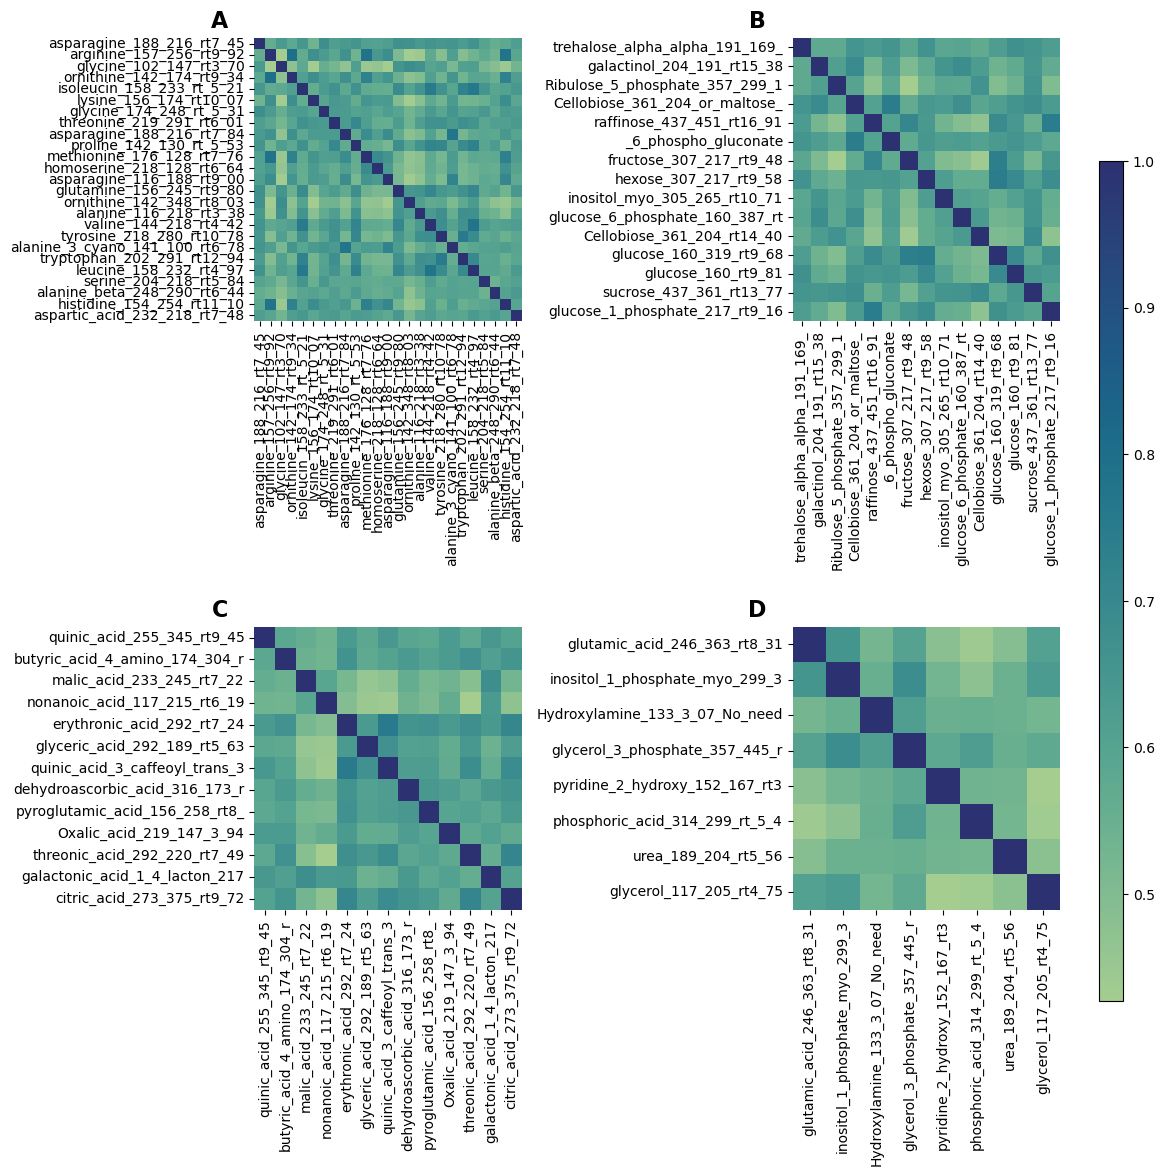

In [100]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Adjust size as needed
print(axes)

# descriptions for each subplot
descriptions = ["A", "B", "C", "D"]

# iterate over dictionaries, axes, and descriptions to generate heatmaps
for ax, jaccard_indices, desc in zip(axes.flatten(), dictionaries, descriptions):
    print(ax)
    generate_heatmap(jaccard_indices, ax)
    ax.text(-0.1, 1.1, desc, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # position of the colorbar
# Generate a colorbar using the last heatmap colormap
plt.colorbar(axes[0, 0].collections[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to fit the colorbar
plt.show()

/tmp/ipykernel_6628/2213650344.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to fit the colorbar


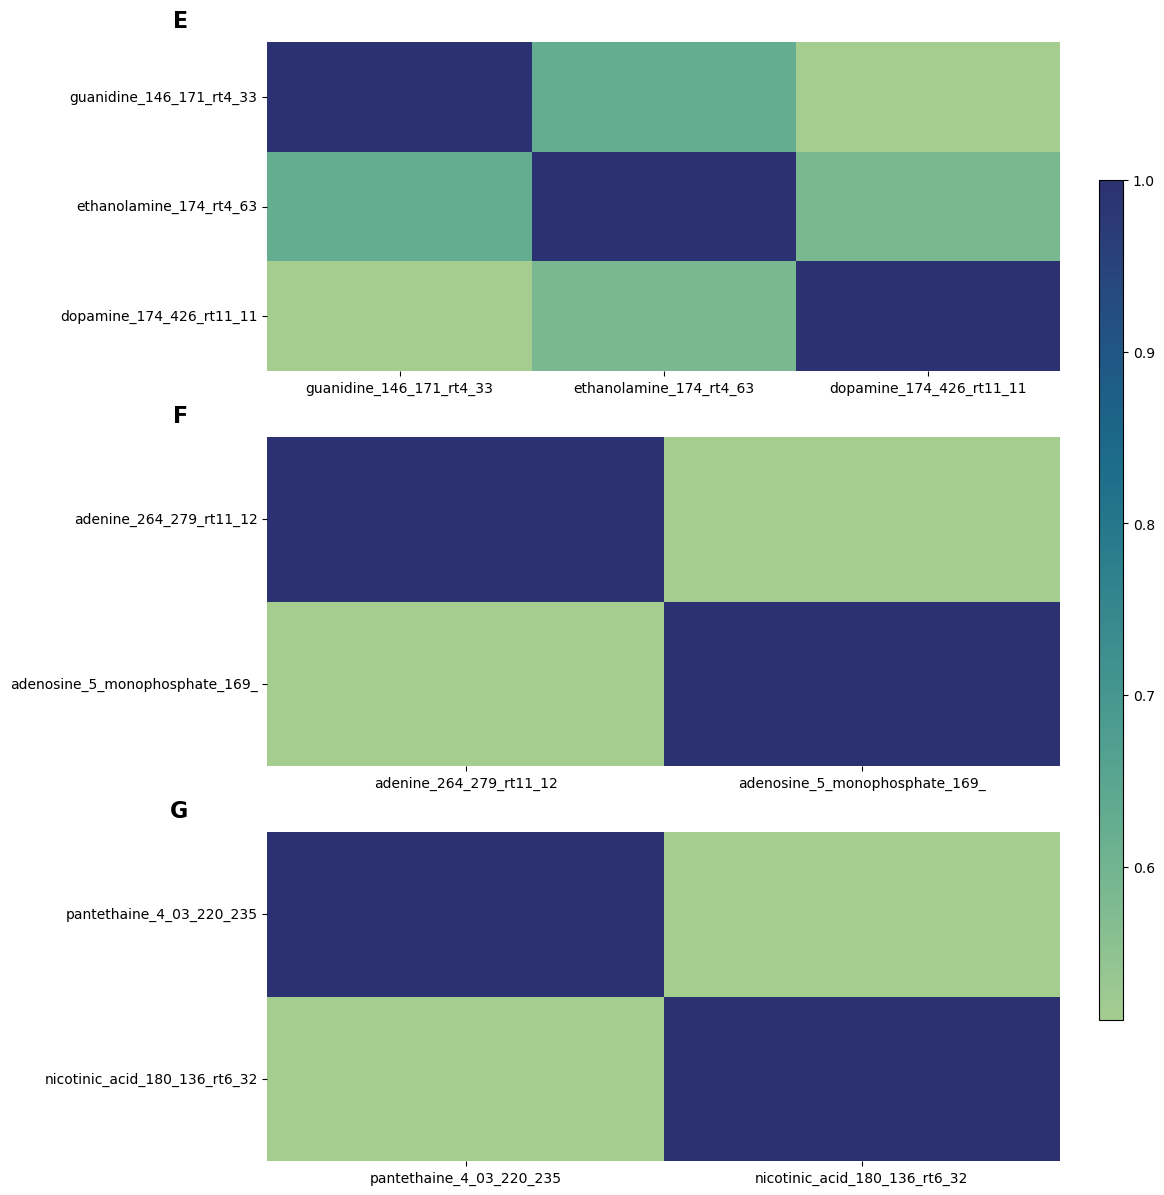

In [101]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # Adjust size as needed

# Descriptions for each subplot
descriptions = ["E", "F", "G"]

# Iterate over the dictionaries, axes, and descriptions to generate heatmaps
for ax, jaccard_indices, desc in zip(axes.flatten(), dictionaries2, descriptions):
    generate_heatmap(jaccard_indices, ax)
    ax.text(-0.1, 1.1, desc, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust these values as needed for layout

# Generate a colorbar using the last heatmap's colormap
plt.colorbar(axes[0].collections[0], cax=cbar_ax) # IN CASE OF 1X3 THIS IS 1dimensional, otherwise two

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to fit the colorbar
plt.show()

# LCMS

    ],
    "Porphyrins": [
        "porphobilinogen_2_L"
    ],
    "Flavonoids": [
        "_Rutin"
    ],

In [102]:
aa_derivates_lc, aa_derivates_lc_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Amino_Acids_and_Derivatives/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # dict1
# flavo = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Flavonoids/enrichment_matrix_molf.csv", plot=False) # only one member
nuc_and_deriv_lc, nuc_and_deriv_lc_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Nucleotides_and_Derivatives/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # plotted alone see below
phenolic, phenolic_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Phenolic_Compounds/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # plotted alone se below

# porphyrins = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Porphyrins/enrichment_matrix_molf.csv", plot=False) # only one member
quinic_a_derivates, quinic_a_derivates_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Quinic_Acid_Derivatives/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # dict1 
saponins, saponins_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Saponins/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # dict1
sugar_carb, sugar_carb_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Sugars_and_Sugar_Derivatives/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # plotted alone see below

terpen_triterp, terpen_triterp_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Terpenes_and_Triterpenes/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # dict1
other_lc, other_lc_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Other/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # plotted alone see below
unidentified, unidentified_summary = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/unidentified/enrichment_matrix_molf.csv", plot=False, summary_stats=True) # alone see below


dict_1 = [aa_derivates_lc, quinic_a_derivates, saponins, terpen_triterp]


### LCMS summary statistic for each category

In [103]:
lcms_categories2.keys()

dict_keys(['Amino_Acids_and_Derivatives', 'Quinic_Acid_Derivatives', 'Phenolic_Compounds', 'Sugars_and_Sugar_Derivatives', 'Nucleotides_and_Derivatives', 'Terpenes_and_Triterpenes', 'Saponins', 'Porphyrins', 'Flavonoids', 'Other', 'unidentified'])

In [105]:
lcms_summary = pd.DataFrame({"Amino_Acids_and_Derivatives": aa_derivates_lc_summary,
"Quinic_Acid_Derivatives": quinic_a_derivates_summary,
"Phenolic_Compounds": phenolic_summary,
"Sugars_and_Sugar_Derivatives": sugar_carb_summary,
"Nucleotides_and_Derivatives": nuc_and_deriv_lc_summary,
"Terpenes_and_Triterpenes": terpen_triterp_summary,
"Saponins": saponins_summary,
"Other": other_lc_summary,
"unidentified": unidentified_summary
}).round(2).T
lcms_summary


,mean,median,std_dev,min,max,q25,q50,q75
Amino_Acids_and_Derivatives,0.58,0.60,0.12,0.28,0.86,0.51,0.60,0.65
Quinic_Acid_Derivatives,0.60,0.60,0.08,0.42,0.82,0.58,0.60,0.64
Phenolic_Compounds,0.63,0.64,0.08,0.33,0.81,0.59,0.64,0.68
Sugars_and_Sugar_Derivatives,0.59,0.60,0.08,0.30,0.77,0.55,0.60,0.64
Nucleotides_and_Derivatives,0.57,0.59,0.08,0.43,0.68,0.53,0.59,0.63
Terpenes_and_Triterpenes,0.55,0.57,0.10,0.31,0.68,0.49,0.57,0.63
Saponins,0.55,0.59,0.11,0.26,0.75,0.49,0.59,0.63
Other,0.57,0.60,0.10,0.34,0.74,0.52,0.60,0.63
unidentified,0.60,0.61,0.06,0.37,0.79,0.57,0.61,0.64


### plot jaccard heatmap for each LCMS category

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]
Axes(0.125,0.53;0.352273x0.35)
Axes(0.547727,0.53;0.352273x0.35)
Axes(0.125,0.11;0.352273x0.35)
Axes(0.547727,0.11;0.352273x0.35)


/tmp/ipykernel_6628/2567329311.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to fit the colorbar


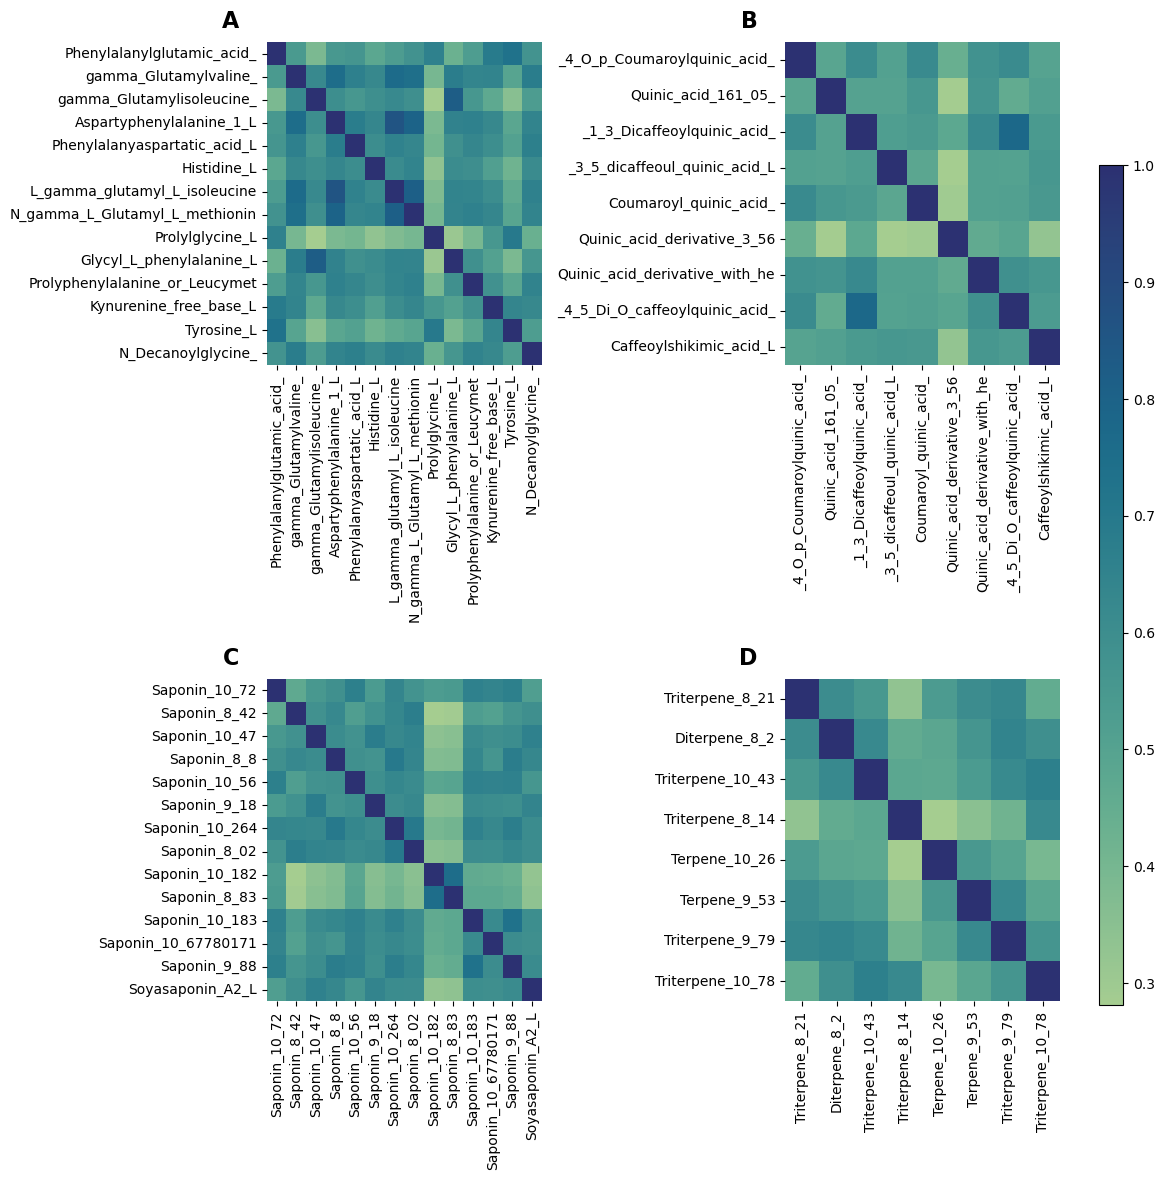

In [34]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Adjust size as needed
print(axes)

# descriptions for each subplot
descriptions = ["A", "B", "C", "D"]

# iterate over dictionaries, axes, and descriptions to generate heatmaps
for ax, jaccard_indices, desc in zip(axes.flatten(), dict_1, descriptions):
    print(ax)
    generate_heatmap(jaccard_indices, ax)
    ax.text(-0.1, 1.1, desc, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # position of the colorbar
# Generate a colorbar using the last heatmap colormap
plt.colorbar(axes[0, 0].collections[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to fit the colorbar
plt.show()

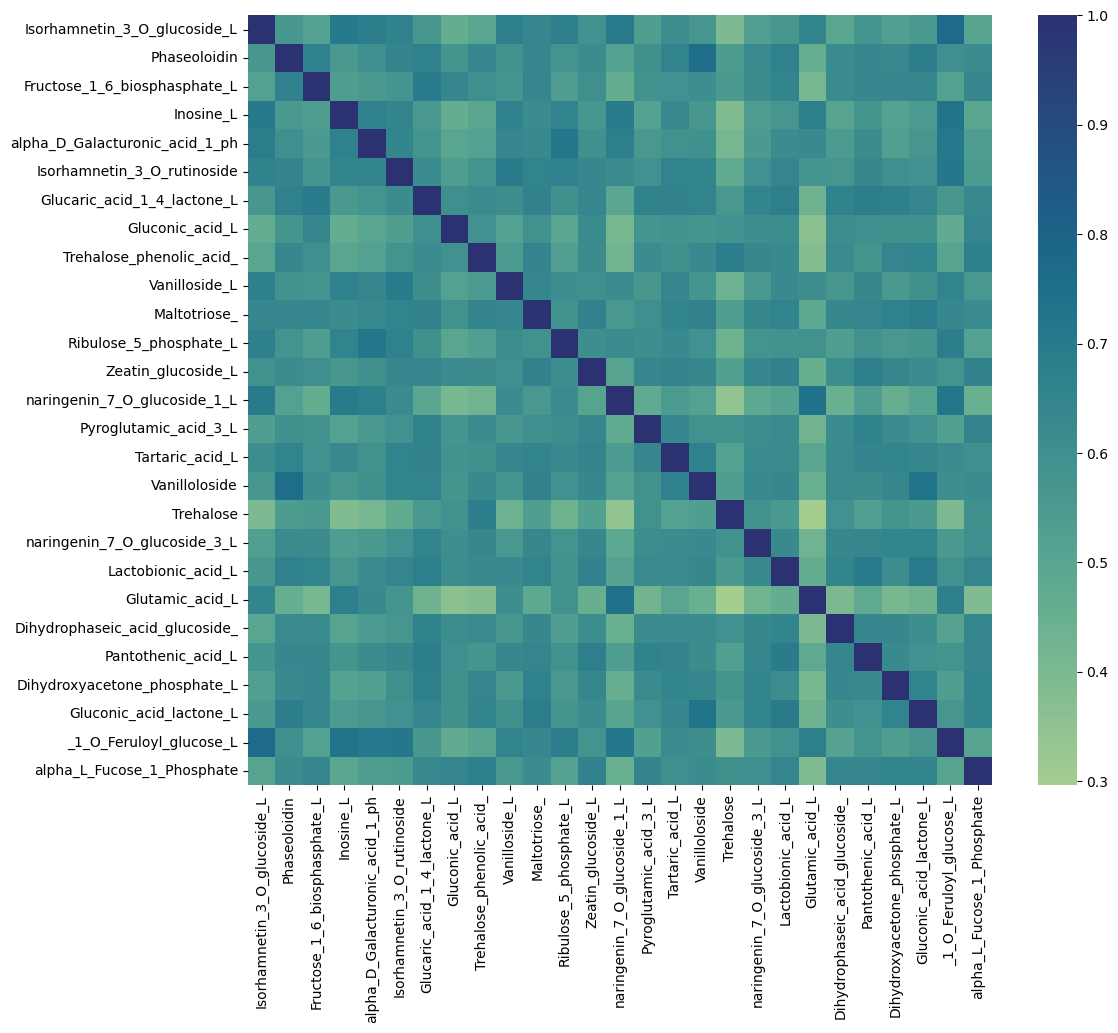

In [29]:
sugar_carb = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Sugars_and_Sugar_Derivatives/enrichment_matrix_molf.csv", plot=True)


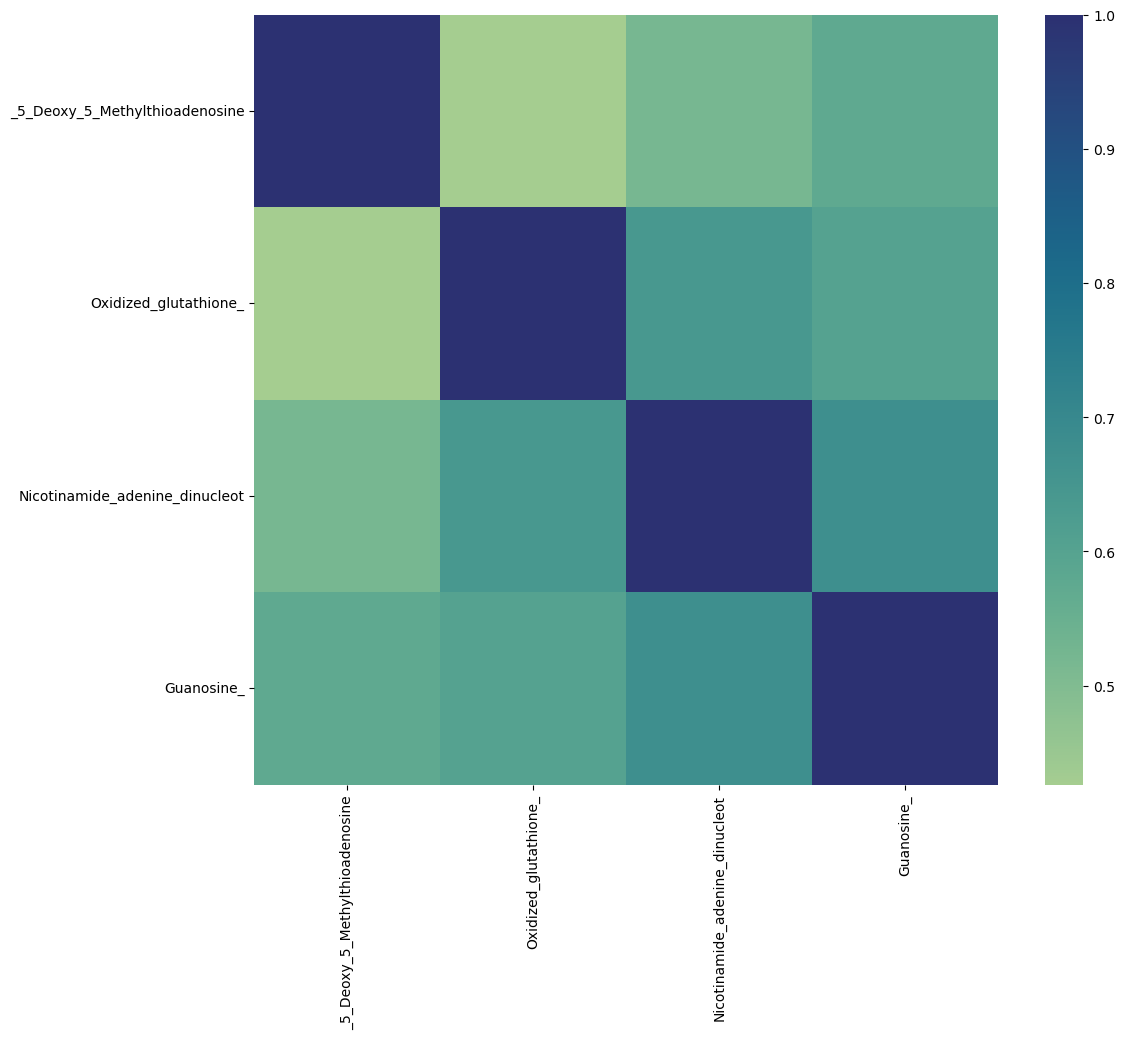

In [36]:
nuc_and_deriv_lc = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Nucleotides_and_Derivatives/enrichment_matrix_molf.csv", plot=True) 


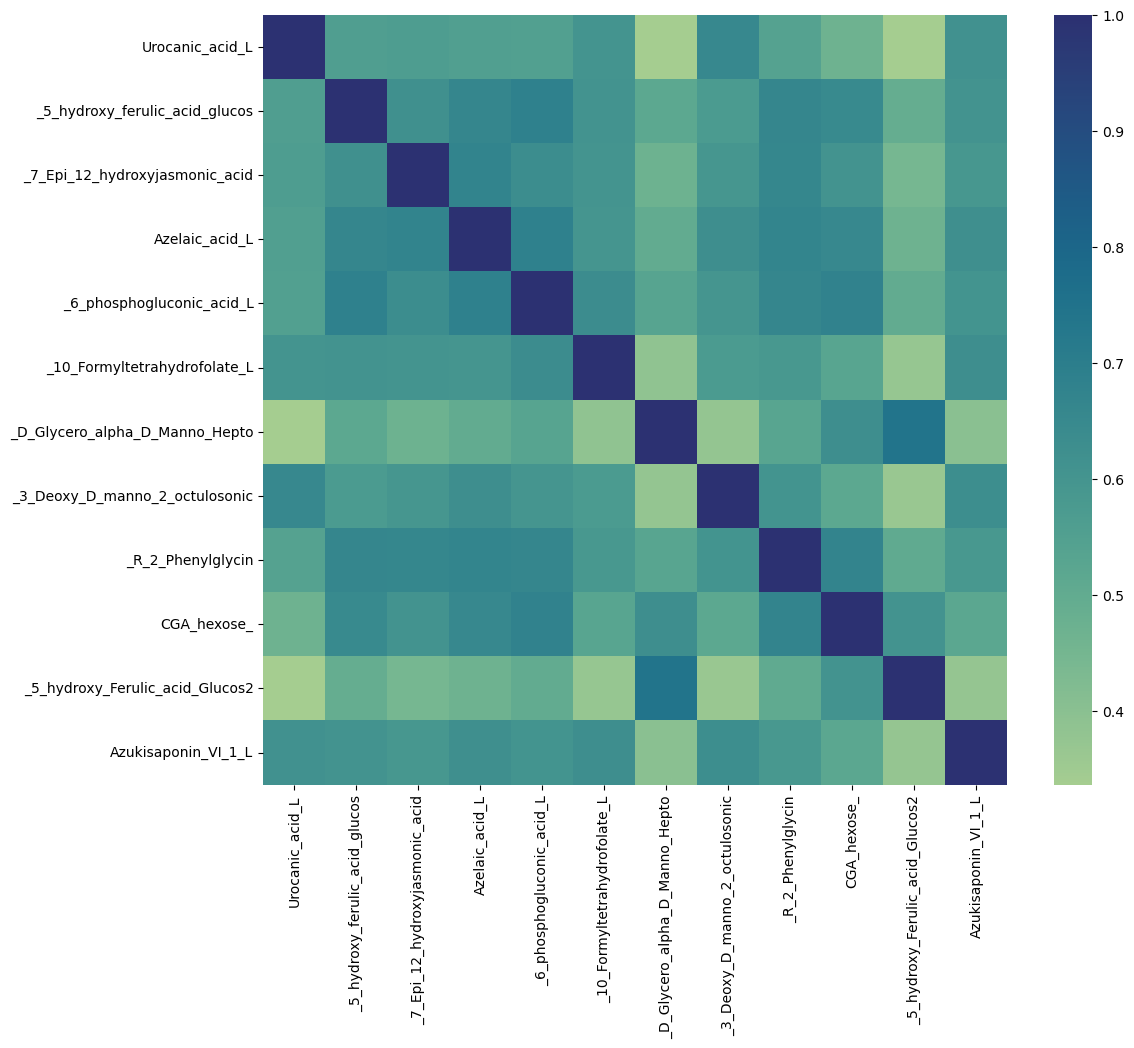

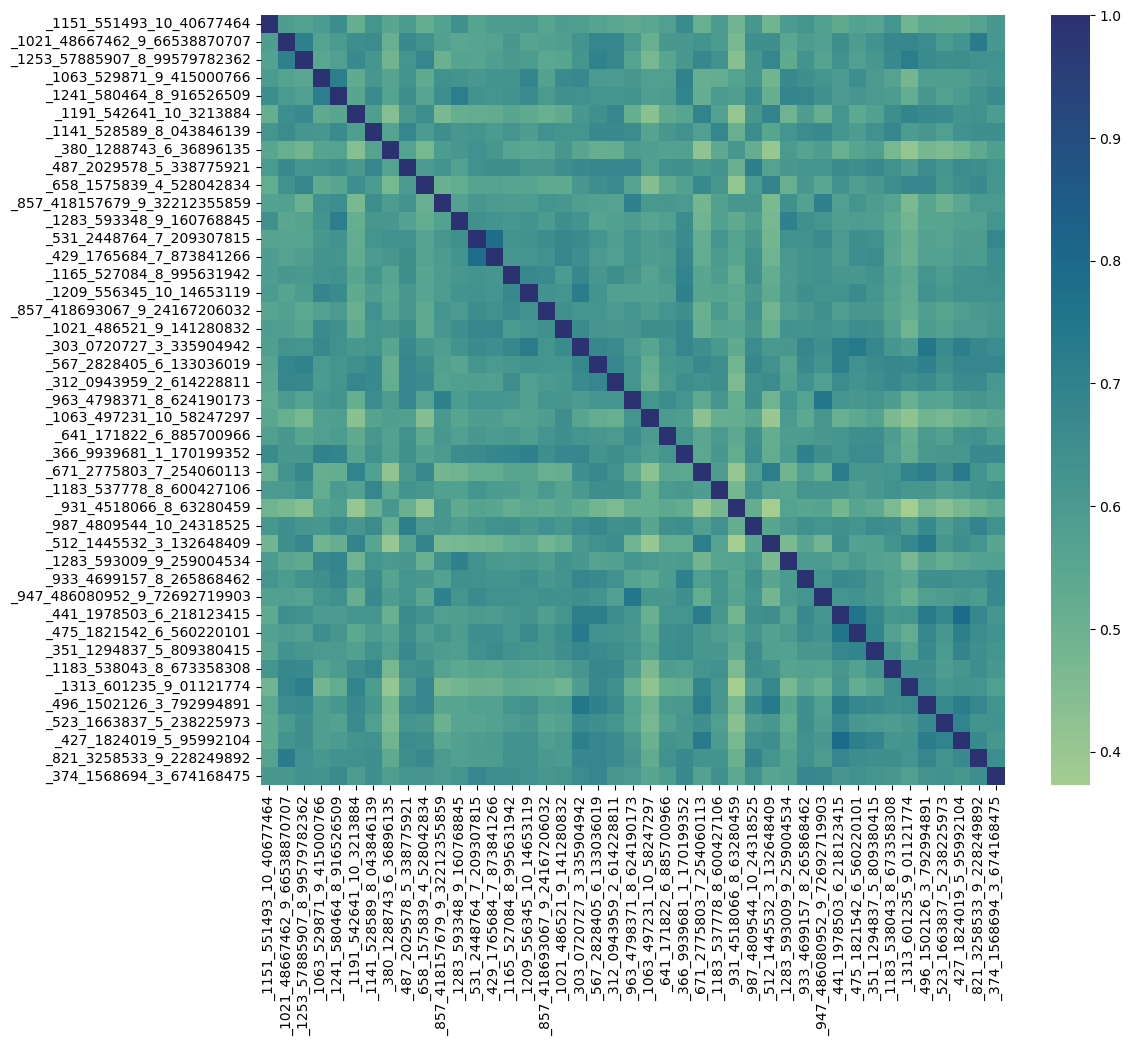

In [37]:
other_lc = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/Other/enrichment_matrix_molf.csv", plot=True) # alone see below
unidentified = pw_jaccard_index("/home/t44p/PW_rawdata/results/full_lasso/lcms/goea/unidentified/enrichment_matrix_molf.csv", plot=True) # alone see below
